# Training a Network
This notebook will guide you through the task of training a segmentation network within the htc framework. This is a complex task and a full training setup with all the details would be too much for a single tutorial. Hence, we consider an artificial simple example of segmenting only heart and lung in images from all annotators and we also don't use the full dataset but only a reduced version to keep the training time short.

In summary, we need the following components to solve this training task:
- Data specification which defines our training setup (folds and splits).
- A lightning class where we define the model and our training/validation.
- A configuration file with all our training settings.
- Training of the network.
- Aggregating the fold results and visualizing the results.
- At the very end of our experiments: compute the results on the (untouched) test set.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd
from IPython.display import JSON

from htc import (
    Config,
    DataPath,
    DataSpecification,
    MetricAggregation,
    SpecsGeneration,
    create_class_scores_figure,
    settings,
)

tutorial_dir = Path().absolute()
assert (tutorial_dir / "LightningImageThoracic.py").exists(), (
    "Cannot find the network_training directory. Please make sure that the working directory contains this notebook"
    f" (current working directory: {tutorial_dir})"
)

## Data Specification
The data specification is a fundamental concept and is required for any training task. Here you define which images should be loaded in which fold/split. Since we deal with hierarchical data (multiple images per subject), we usually make cuts on the subject and not on the image level, i.e. we put all  images from the same subject into one split.

To keep it simple, we use only 2 folds with three splits each (train, validation and test). We will use images from 3 pigs in total. For the generation of the specs file, we can use the `SpecsGeneration` class and here we only need to overwrite the `generate_folds()` method which returns a list of dicts with each dict defining one fold.

In [2]:
class SpecsGenerationThoracic(SpecsGeneration):
    def __init__(self):
        # Unique name of the resulting specs file
        super().__init__(name="pigs_thoracic_2folds")

        # We will divide the data into an untuched test set and the rest will be divided into 2 folds
        # Here, we are doing leave-one-subject-out cross validation with two subjects and have an additional subject in the untouched test set
        self.subjects_folds = ["P093", "P094"]
        self.subjects_test = ["P095"]

    def generate_folds(self) -> list[dict]:
        # We only need a subset of the available images: those from our selected subjects (filter_subjects_*) and here only the images which contain our labels (filter_labels)
        data_dir = settings.data_dirs["HeiPorSPECTRAL"]
        filter_labels = lambda p: set(p.annotated_labels(annotation_name="all")) & {"heart", "lung"}
        filter_subjects_test = lambda p: p.subject_name in self.subjects_test
        filter_subjects_folds = lambda p: p.subject_name in self.subjects_folds

        # Untouched test set
        paths_test = list(DataPath.iterate(data_dir, filters=[filter_subjects_test, filter_labels]))
        imgs_test = [p.image_name() for p in paths_test]

        # Fold paths
        paths_folds = list(DataPath.iterate(data_dir, filters=[filter_subjects_folds, filter_labels]))

        data_specs = []
        for fold_subject in self.subjects_folds:
            # Divide the folds into train and validation
            imgs_train = [p.image_name() for p in paths_folds if p.subject_name == fold_subject]
            imgs_val = [p.image_name() for p in paths_folds if p.subject_name != fold_subject]

            fold_specs = {
                "fold_name": f"fold_{fold_subject}",
                "train": {
                    "image_names": imgs_train,
                },
                "val": {
                    "image_names": imgs_val,
                },
                "test": {
                    "image_names": imgs_test,
                },
            }

            data_specs.append(fold_specs)

        return data_specs


SpecsGenerationThoracic().generate_dataset(target_folder=tutorial_dir)
specs_path = tutorial_dir / "pigs_thoracic_2folds.json"

When you exectue the above cell, a JSON file will be created in the folder of this notebook. This file defines our two folds and the subject which is used for training (`P093` in the first and `P094` in the second fold) and validation (`P094` in the first and `P093` in the second fold). For each split, we simply list the images which belong to this split. `P095` is used as test set for all folds The test set must remain untouched until all experiments are complete and we are happy with the performance on the validation set. Only then is it time to take a look at the test set.
> The list of image names is as flexible as the `DataPath.from_image_name()` function. This means you can also specify the annotations you want to use on a per image basis, i.e. `image_name@name1&name`.

In [3]:
JSON(specs_path)

<IPython.core.display.JSON object>

In [4]:
# We can also easily use this specs file in the htc framework
DataSpecification(specs_path).table()

,fold_name,split_name,image_name,subject_name,timestamp
0,fold_P093,train,P093#2021_04_28_15_30_33,P093,2021_04_28_15_30_33
1,fold_P093,train,P093#2021_04_28_15_30_50,P093,2021_04_28_15_30_50
2,fold_P093,train,P093#2021_04_28_15_31_07,P093,2021_04_28_15_31_07
3,fold_P093,train,P093#2021_04_28_15_31_48,P093,2021_04_28_15_31_48
4,fold_P093,train,P093#2021_04_28_15_32_06,P093,2021_04_28_15_32_06
...,...,...,...,...,...
283,fold_P094,val,P093#2021_04_28_15_58_20,P093,2021_04_28_15_58_20
284,fold_P094,val,P093#2021_04_28_15_58_37,P093,2021_04_28_15_58_37
285,fold_P094,val,P093#2021_04_28_15_59_13,P093,2021_04_28_15_59_13
286,fold_P094,val,P093#2021_04_28_15_59_31,P093,2021_04_28_15_59_31


## Lightning Class
The lightning class defines our training based on a batch of images, i.e. the model we want to use, the computation of the loss or the validation of images. This is based on the [Lightning framework](https://www.pytorchlightning.ai/) with some additional extensions for our data. In our task, we want to predict segmentation masks on full images, so we can re-use a lot of the existing [`LightningImage`](../../htc/models/image/LightningImage.py) class which, for example, already computes the dice loss during training.

Hence, in our own class, we inherit form [`LightningImage`](../../htc/models/image/LightningImage.py) and just overwrite the parts which we want to change.  For showcase purposes, we overwrite the `training_step()` method and add the [focal loss](https://docs.monai.io/en/latest/losses.html#focalloss) as additional loss (additional to the dice and cross entropy loss) for our training. In similar ways, you can basically overwrite any methods and adapt the training to your needs. You can find the class [`LightningImageThoracic`](LightningImageThoracic.py) in the same folder as this notebook.

Please note that we also did not overwrite any validation or test methods (e.g. `validation_step()`). This is because LightningImage already inherits from [`EvaluationMixin`](../../htc/models/common/EvaluationMixin.py) which computes some default metrics like the dice score useful for segmentation tasks as ours.

## Training Configuration
The specification of your training is summarized in a configuration file. In the htc framework, we are using simple JSON files for this purpose. Here you define which data you want to use, the augmentations, etc. To make it simple, we inherit from the default configuration of the image model and just adapt the parts we need. These are:
- Which lightning class do we want to use?
- On which data do we want to train? (i.e. which specs file to use)
- Which annotations to load?
- How do we want to aggregate the metric scores? On the class-level or on the image-level? In the pretrained networks, we aggregated on the image-level yielding one score per subject. This makes only sense if the complete image is annotated and you want to know the segmentation performance for an image. Here, however, we do not have fully-segmented images, so an image-level score is less meaningful. Instead, we want to look at the class-level scores yielding a metric score per organ.
- Which classes do we want to use?

In [5]:
config = Config.load_config("default", "image")
config["inherits"] = "models/image/configs/default"
config["lightning_class"] = tutorial_dir / "LightningImageThoracic.py>LightningImageThoracic"
config["input/data_spec"] = tutorial_dir / "pigs_thoracic_2folds.json"
config["input/annotation_name"] = ["polygon#annotator1", "polygon#annotator2", "polygon#annotator3"]
config["validation/checkpoint_metric_mode"] = "class_level"

# We want to merge the annotations from all annotators into one label mask
config["input/merge_annotations"] = "union"

# We have a two-class problem and we want to ignore all unlabeled pixels
# Everything which is >= settings.label_index_thresh will later be considered invalid
config["label_mapping"] = {
    "heart": 0,
    "lung": 1,
    "unlabeled": settings.label_index_thresh,
}

# Reduce the training time
config["trainer_kwargs/max_epochs"] = 2

# Progress bars can cause problems in Jupyter notebooks so we disable them here (training does not take super long)
config["trainer_kwargs/enable_progress_bar"] = False

config_path = tutorial_dir / "config_thoracic.json"
config.save_config(config_path)
JSON(config_path)

<IPython.core.display.JSON object>

## Start the Training
We now have everything together to start the training of our network. Simply run the `htc training` command and pass the modle type (image model in our case) and path to the config as arguments.
> &#x26a0;&#xfe0f; Starting a training session in a Jupyter notebook is usually not a good idea. Instead, it is advisable to use a [`screen`](https://linuxize.com/post/how-to-use-linux-screen/) environment so that your training runs in the background and you can return later to check for the status.

> There is also a `--fold FOLD_NAME` switch if you only want to train only one fold. This is useful for debugging.

In [6]:
!htc training --model image --config $config_path
assert _exit_code == 0, "Training was not successful"  # noqa: F821

folds ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--[INFO][htc] Starting training of the fold fold_P093          run_training.py:255
folds ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--[INFO][htc] The following config will be used for training:   run_training.py:71
[INFO][htc] {'config_name': 'config_thoracic',                run_training.py:72
 'dataloader_kwargs': {'batch_size': 5, 'num_workers': 1},                      
 'input': {'annotation_name': ['polygon#annotator1',                            
                               'polygon#annotator2',                            
                               'polygon#annotator3'],                           
           'data_spec':                                                         
'/mnt/ssd_8tb/htc/src/tutorials/network_training/pigs_thoraci                   
c_2folds.json',                                                                 
           'epoch_size': 500,                                           

The results will be stored in your results folder (as set by the `PATH_HTC_RESULTS` environment variable). There will be a subfolder for each fold with the following files:
- A copy of your configuration file (`config.json`).
- A copy of your data specification file (`data.json`).
- The trained network (e.g. `epoch=02-dice_metric=0.90.ckpt`).
- TensorBoard events file (e.g. `events.out.tfevents.1670877422.e130-pc27.2610059.0`). This file contains the variables you logged via `self.log()`, e.g. the value of our focal loss. It is also possible to start TensorBoard in the results folder and visualize the values while the network is still training (helpful for debugging).
- The log messages you may have seen in your console (or in the above cell) during training saved in a text file (`log.txt`).
- Statistics about your CPU and GPU utilization during training (e.g. `system_log_2022-12-12_21-37-00.json`).
- Statistics about the seen images during training (`trainings_stats.npz`).
- A table with the result of the validation metrics like the dice score computed in the validation step (`validation_results.pkl.xz`).

In [7]:
sorted(settings.training_dir.rglob("*"))

[PosixPath('/mnt/ssd_8tb/htc/results_test/training/image'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P093'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P093/config.json'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P093/data.json'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P093/epoch=02-dice_metric=1.00.ckpt'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P093/events.out.tfevents.1674319027.e130-pc27.1224897.0'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P093/hparams.yaml'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoraci

## Aggregating and Visualizing
After we trained our network, we would like to know wheter it performs well. You could have visualized the metric scores with TensorBoard but this is only a single view on a single fold. What we want is a holistic view on our network performance. This includes aggregation across folds and correctly aggregating with respect to the hierarchy in the data. The later is easy to miss: we cannot simply average our performance scores across all images as the number of images per subject is not always the same (even not in our standardized dataset). What is more, images from one subject are not independent from each other leading to common [pitfalls](https://arxiv.org/abs/2206.01653). Hence, we always first want to aggregate for each subject independently from each other and then across subjects. In the htc framework, the [`MetricAggregation`](../../htc/models/common/MetricAggregation.py) class is responsible for this.

So, what we would like to have is a summary of our training run with nice visualizations for our scores which are aggregated while respecting the hierarchy in the data. Here, the general idea is to write one Jupyter Notebook which contains all these aggregations and visualizations for one training run and then use this as a template to generate it for every trained network. The notebook itself is highly task-specific but there are some notebook in this repository which you can use as reference. Especially for this tutorial, there is also a notebook in this folder which we now want to use. To use this as template for our training run, execute the following command:

In [8]:
notebook_path = tutorial_dir / "ExperimentAnalysis.ipynb"
assert notebook_path.exists()

In [9]:
!htc table_generation --notebook $notebook_path
assert _exit_code == 0, "Table generation was not successful"  # noqa: F821

[INFO][htc] Will generate results for the following  run_table_generation.py:417
runs:                                                                           
[INFO][htc]                                          run_table_generation.py:419
image/2023-01-21_17-37-03_config_thoracic                                       
Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:-- 0:00:00 ?[WARNING][htc] The log of the fold                   run_table_generation.py:181
/mnt/ssd_8tb/htc/results_test/training/image/2023-01                            
-21_17-37-03_config_thoracic/fold_P093 contains                                 
warnings                                                                        
[WARNING][htc] The log of the fold                   run_table_generation.py:181
/mnt/ssd_8tb/htc/results_test/training/image/2023-01                            
-21_17-37-03_config_thoracic/fold_P094 contains                                 
warnings                           

In the run directory for our training run, there are now several new files:
- Most importantly, `ExperimentAnalysis.html` which gives you all the promised visualizations from before.
- `config.json` and `data.json` for easier access the configuration and data specifcation for the complete training run.
- `validation_table.pkl.xz` is a table with all the validation data from all folds (we are using this table in the generated notebook).

In [10]:
run_dir = sorted((settings.training_dir / "image").iterdir())[-1]
run_folder = run_dir.name
sorted(run_dir.iterdir())

[PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/ExperimentAnalysis.html'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/config.json'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/data.json'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P093'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/fold_P094'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/log.txt'),
 PosixPath('/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03_config_thoracic/validation_table.pkl.xz')]

> The `table_generation` command iterates over all available run directories and applies your notebook template to all "empty" runs. That is, if you want to re-apply a notebook, simply delete the existing `ExperimentAnalysis.html` and `validation_table.pkl.xz` files. They will be re-generated.

## Bonus: Visualizing Network Predictions
If you are (not only) interested in the aggregated visualizations but would also get a feeling of the network predictions, then we got you covered. With the following command, you will get a figure for each image in the validation set which visualized the network output together with the network confidence (but uncalibrated!) and the reference segmentation as comparison. The command works on each fold separately. It will load the network for the corresponding fold and then make predictions for all images which are part of the validation set of this fold. This means that not the same network is used for all images.
> Adding the `--test` switch will give you the predictions for all images in the test set (by default with network ensembling across the folds).

In [11]:
!htc image_figures --model image --run-folder $run_folder --hide-progressbar
assert _exit_code == 0, "Figure generation was not successful"  # noqa: F821

[INFO][htc.no_duplicates] Found pretrained run in the local      HTCModel.py:275
training dir at                                                                 
/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03                
_config_thoracic                                                                
[INFO][htc] Working on run dir:                        ValidationPredictor.py:17
/mnt/ssd_8tb/htc/results_test/training/image/2023-01-2                          
1_17-37-03_config_thoracic                                                      


## Performance On the Untouched Test Set
So far, we only assessed our network performance on the validation data and this is a good thing. For all your experiments and network comparisons, you should use the validation set. Only at the very end, it is time to analyse the performance on the untouched test set. Let's assume we are finished with our experiments and would like to know about the performance on the test set. For this you can use the following command which will create a `test_table.pkl.xz` in our run directory. This is very similar to our `validation_table.pkl.xz` just with scores on the test set and no per epoch values.

In [12]:
!htc tables --model image --run-folder $run_folder --test --metrics DSC
assert _exit_code == 0, "Table generation was not successful"  # noqa: F821

[INFO][htc.no_duplicates] Found pretrained run in the local      HTCModel.py:275
training dir at                                                                 
/mnt/ssd_8tb/htc/results_test/training/image/2023-01-21_17-37-03                
_config_thoracic                                                                
Dataloader ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:25m 0:00:25


In [13]:
df_test = pd.read_pickle(run_dir / "test_table.pkl.xz")
config = Config(run_dir / "config.json")
agg_test = MetricAggregation(df_test, config, metrics=["dice_metric"])
df_test.head()

,dice_metric,dice_metric_image,confusion_matrix,ece,used_labels,image_name,subject_name,timestamp
0,[1.0],1.0,"[[0, 0], [0, 15823]]","{'error': 0.001354992389678955, 'accuracies': ...",[1],P095#2021_05_02_19_36_34,P095,2021_05_02_19_36_34
1,[1.0],1.0,"[[0, 0], [0, 16437]]","{'error': 0.0015941262245178223, 'accuracies':...",[1],P095#2021_05_02_19_36_51,P095,2021_05_02_19_36_51
2,[1.0],1.0,"[[0, 0], [0, 16178]]","{'error': 0.001563429832458496, 'accuracies': ...",[1],P095#2021_05_02_19_36_16,P095,2021_05_02_19_36_16
3,[1.0],1.0,"[[0, 0], [0, 20406]]","{'error': 0.001386880874633789, 'accuracies': ...",[1],P095#2021_05_02_19_38_36,P095,2021_05_02_19_38_36
4,[1.0],1.0,"[[0, 0], [0, 31249]]","{'error': 0.0015866756439208984, 'accuracies':...",[1],P095#2021_05_02_19_35_18,P095,2021_05_02_19_35_18


We could now show similar visualizations as before but to keep it simple, we only look at the class scores.

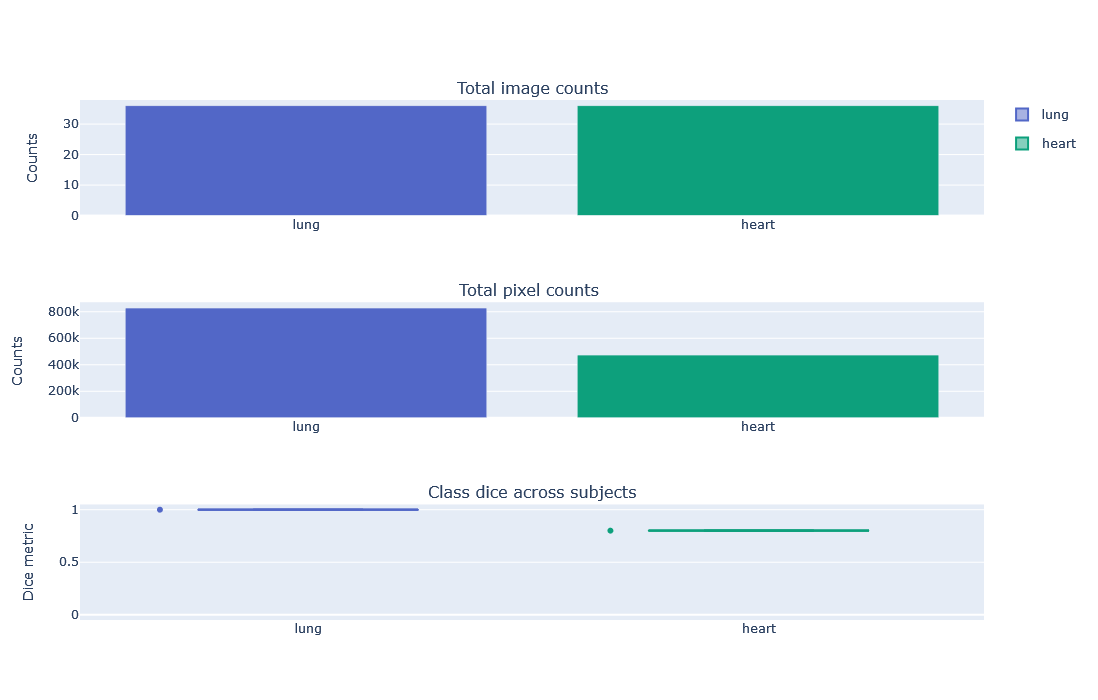

In [14]:
create_class_scores_figure(agg_test)